# Anomaly Detection With Discord Discovery

<strong>Author:</strong> Tyler Marrs<br />
<strong>Date:</strong> January 18th 2019

This notebook shows how you can find discords within a matrix profile using a <a href="https://www.kaggle.com/boltzmannbrain/nab">NAB dataset</a>. We will be working with the NYC Taxi dataset.

## Data Overview

The data consists of the number of taxi passengers from 2014-07-01 to 2015-01-31. There are 5 known anomalies during these periods:

* NYC Marathon - 2014-11-02
* Thanksgiving - 2014-11-27
* Christmas - 2014-12-25
* New Years - 2015-01-01
* Snow Blizzard - 2015-01-26 and 2015-01-27

I will see how close the anomaly detection is using matrix profiles.

In [1]:
from matrixprofile import *
from matrixprofile.discords import discords

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import operator
import random
from datetime import datetime , timedelta, timezone
from sklearn.decomposition import PCA


%matplotlib inline

In [3]:
plt.style.use('https://raw.githubusercontent.com/TDAmeritrade/stumpy/main/docs/stumpy.mplstyle')

## Load Data

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv')

In [5]:
df.head()

timestamp  value
0  2014-07-01 00:00:00  10844
1  2014-07-01 00:30:00   8127
2  2014-07-01 01:00:00   6210
3  2014-07-01 01:30:00   4656
4  2014-07-01 02:00:00   3820

In [6]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [7]:
df = df.set_index('timestamp').sort_index()

In [8]:
df.shape

(10320, 1)

In [9]:
df.head()

value
timestamp                 
2014-07-01 00:00:00  10844
2014-07-01 00:30:00   8127
2014-07-01 01:00:00   6210
2014-07-01 01:30:00   4656
2014-07-01 02:00:00   3820

## Resample Hourly

Originally the dataset is within 30 minute increments.

In [10]:
df = df.resample('1H').sum()

In [11]:
df.head()

value
timestamp                 
2014-07-01 00:00:00  18971
2014-07-01 01:00:00  10866
2014-07-01 02:00:00   6693
2014-07-01 03:00:00   4433
2014-07-01 04:00:00   4379

In [12]:
a = df.values.squeeze()

# subsequence length to compute the matrix profile
# since we have hourly measurements and want to find daily events,
# we will create a length of 24 - number of hours in a day
m = 24
profile = matrixProfile.stomp(a,m)

In [13]:
df['profile'] = np.append(profile[0],np.zeros(m-1)+np.nan)
df['profile_index'] = np.append(profile[1], np.zeros(m - 1) + np.nan)

## Plot Matrix Profile

Below is a plot of the hourly data and the matrix profile. Visually, you can see both motifs and discords. We are interested in finding the discords which are high peaks in the plot. A couple of periods jump out that seem close to Thanksgiving and the snow storm.

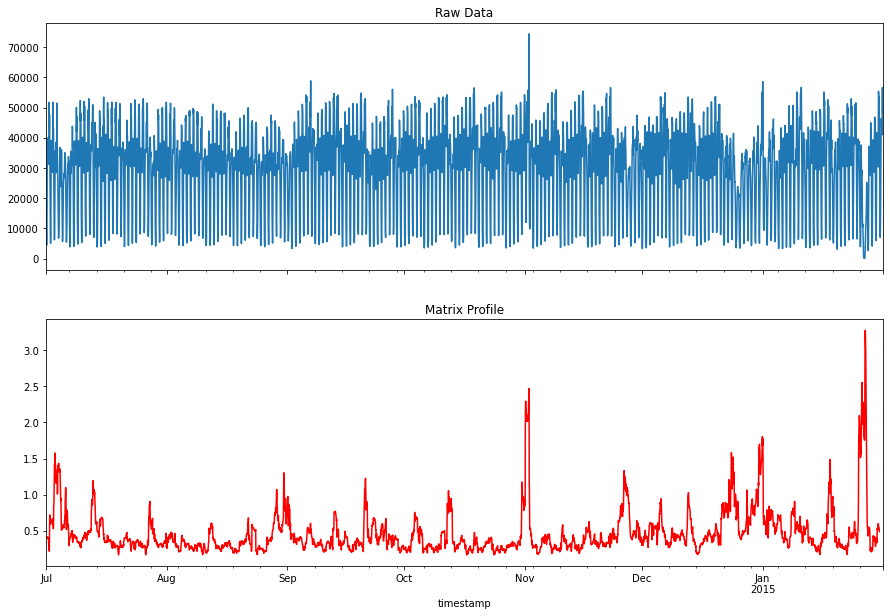

In [14]:
#Plot the signal data
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(15,10))
df['value'].plot(ax=ax1, title='Raw Data')

#Plot the Matrix Profile
df['profile'].plot(ax=ax2, c='r', title='Matrix Profile')
plt.show()

In [15]:
# exclude up to a day on the left and right side
ex_zone = 24

# we look for the 5 events specified in the data explaination
anoms = discords(df['profile'], ex_zone, k=5)

In [16]:
df.iloc[anoms]

value   profile  profile_index
timestamp                                          
2015-01-27 09:00:00   3874  3.275818          129.0
2014-11-02 00:00:00  48219  2.468237         2304.0
2015-01-25 20:00:00  29503  2.094151         4824.0
2014-12-31 23:00:00  35978  1.803195         4653.0
2014-12-24 00:00:00  20646  1.581157         1466.0

We can see that the anomalies match up with the top 5 discords from the matrix profile.

## My Example

In [17]:
df = pd.read_csv('sp500-1314.csv')

In [18]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()
df.head()

MMM    ABT   ABBV    ACN    ACE    ACT   ADBE    ADT    AES  \
Date                                                                        
2013-01-02  90.50  30.84  32.71  65.74  78.01  84.21  38.34  44.42  10.71   
2013-01-03  90.39  32.02  32.44  65.50  78.42  85.92  37.75  44.51  10.65   
2013-01-04  91.06  31.83  32.03  65.86  78.52  85.30  38.13  45.12  10.90   
2013-01-07  91.18  32.09  32.10  65.58  77.57  85.66  37.94  45.04  10.56   
2013-01-08  91.19  32.10  31.40  65.96  76.30  86.68  38.14  44.85  10.56   

              AET  ...    XEL   XRX   XLNX     XL    XYL   YHOO    YUM    ZMH  \
Date               ...                                                          
2013-01-02  45.05  ...  25.35  6.88  35.55  24.39  26.67  20.08  64.50  66.46   
2013-01-03  44.10  ...  25.28  6.88  35.48  24.44  26.58  19.78  64.90  67.41   
2013-01-04  44.30  ...  25.37  6.81  34.98  25.05  26.54  19.86  65.61  67.75   
2013-01-07  44.97  ...  25.10  6.92  34.84  25.01  26.19  19.40  65.20  67.92   
2013-01-08  43.42  ...  25.15  6.91  34.13  24.89  25.87  19.66  62.46  68.02   

             ZION  ZTS  
Date                    
2013-01-02  21.77  NaN  
2013-01-03  21.80  NaN  
2013-01-04  22.42  NaN  
2013-01-07  22.31  NaN  
2013-01-08  21.87  NaN  

[5 rows x 496 columns]

In [19]:
temp = pd.DataFrame(df['MMM'])
temp.shape

(504, 1)

In [20]:
temp.head()

MMM
Date             
2013-01-02  90.50
2013-01-03  90.39
2013-01-04  91.06
2013-01-07  91.18
2013-01-08  91.19

In [21]:
#temp = temp.resample('1H').sum()
a = temp.values.squeeze()

In [22]:
temp.head(20)

MMM
Date             
2013-01-02  90.50
2013-01-03  90.39
2013-01-04  91.06
2013-01-07  91.18
2013-01-08  91.19
2013-01-09  92.06
2013-01-10  92.51
2013-01-11  91.93
2013-01-14  92.70
2013-01-15  92.90
2013-01-16  93.19
2013-01-17  93.65
2013-01-18  94.28
2013-01-22  94.84
2013-01-23  95.00
2013-01-24  95.17
2013-01-25  96.05
2013-01-28  96.10
2013-01-29  97.21
2013-01-30  96.25

In [23]:
m = 24
profile = matrixProfile.stomp(a,m)

temp['profile'] = np.append(profile[0],np.zeros(m-1)+np.nan)
temp['profile_index'] = np.append(profile[1], np.zeros(m - 1) + np.nan)

ex_zone = 24
anoms = discords(temp['profile'], ex_zone, k=15)

temp.iloc[anoms]

MMM   profile  profile_index
Date                                       
2013-05-20  107.33  4.984692           48.0
2014-06-17  142.08  4.540709          323.0
2013-12-18  132.58  4.483164          424.0
2013-04-01  101.50  4.428808          138.0
2014-02-24  129.92  3.866216          176.0
2013-09-13  115.23  3.866216          287.0
2014-11-14  158.00  3.829675          302.0
2013-11-07  122.81  3.744174          140.0
2014-08-26  143.83  3.372987           51.0
2014-03-28  131.88  3.122419          337.0
2013-07-18  111.58  2.751171          211.0
2014-07-22  143.49  2.726743          152.0
2014-05-02  137.70  2.708145           25.0
2013-02-06   98.05  2.285917           10.0
2014-09-30  140.92  1.359432          155.0

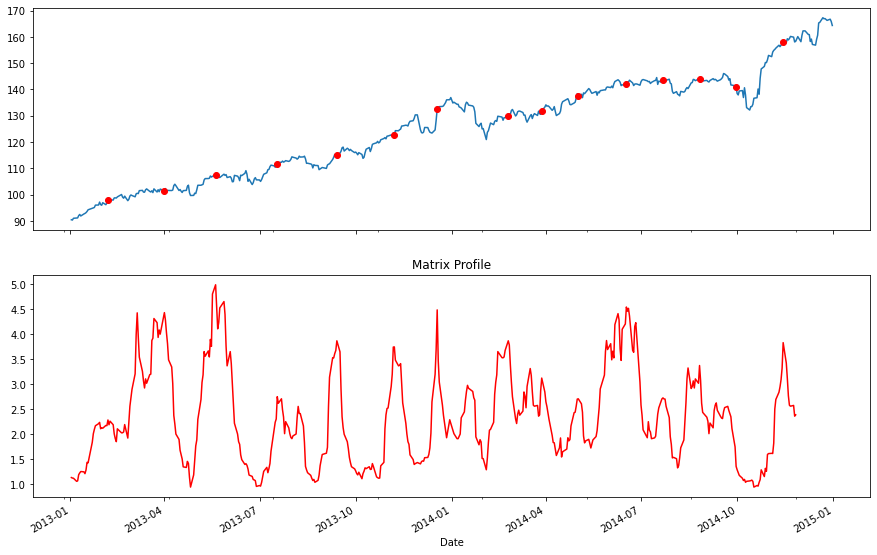

In [24]:
anomalies = temp.iloc[anoms]

#Plot the signal data
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(15,10))
ax1.plot(temp['MMM'])
#.plot(ax=ax1, title='Raw Data')
ax1.plot(anomalies["MMM"], 'ro')

#Plot the Matrix Profile
temp['profile'].plot(ax=ax2, c='r', title='Matrix Profile')


plt.show()

In [25]:
time_dict = {}

for col in df.columns:
    temp = df[col]
    #temp = temp.resample('1H').sum()
    a = temp.values.squeeze()
    
    m = 24
    profile = matrixProfile.stomp(a,m)

    temp['profile'] = np.append(profile[0],np.zeros(m-1)+np.nan)
    temp['profile_index'] = np.append(profile[1], np.zeros(m - 1) + np.nan)

    ex_zone = 24
    try:
        anoms = discords(temp['profile'], ex_zone, k=15)
    except OverflowError:
        continue
    anomalies = temp.iloc[anoms]
    
    for a in anomalies.index:
        if a in time_dict.keys():
            time_dict[a] += 1
        else:
            time_dict[a] = 1

C:\Users\mfsal\Anaconda3\lib\site-packages\matrixprofile\utils.py:177: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean*q_mean)/(m*std*q_std))
C:\Users\mfsal\Anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:118: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(mass(query,tsB).astype(complex)))
C:\Users\mfsal\Anaconda3\lib\site-packages\matrixprofile\utils.py:200: RuntimeWarning: invalid value encountered in true_divide
  res = 2*m*(1-(dot-m*mean[index]*mean)/(m*std[index]*std))
C:\Users\mfsal\Anaconda3\lib\site-packages\matrixprofile\distanceProfile.py:126: RuntimeWarning: invalid value encountered in sqrt
  distanceProfile = np.real(np.sqrt(res.astype(complex)))


In [26]:
sorted_d = dict(sorted(time_dict.items(), key=operator.itemgetter(1),reverse=True))
sorted_d

{Timestamp('2014-11-26 00:00:00'): 81,
 Timestamp('2013-01-02 00:00:00'): 62,
 Timestamp('2013-09-10 00:00:00'): 33,
 Timestamp('2013-09-09 00:00:00'): 31,
 Timestamp('2013-09-13 00:00:00'): 30,
 Timestamp('2013-09-12 00:00:00'): 29,
 Timestamp('2013-05-17 00:00:00'): 28,
 Timestamp('2013-01-25 00:00:00'): 28,
 Timestamp('2014-11-18 00:00:00'): 27,
 Timestamp('2014-11-17 00:00:00'): 27,
 Timestamp('2013-05-29 00:00:00'): 27,
 Timestamp('2013-09-16 00:00:00'): 27,
 Timestamp('2014-09-26 00:00:00'): 25,
 Timestamp('2013-09-11 00:00:00'): 25,
 Timestamp('2013-05-24 00:00:00'): 25,
 Timestamp('2013-05-20 00:00:00'): 24,
 Timestamp('2013-12-19 00:00:00'): 24,
 Timestamp('2013-05-28 00:00:00'): 24,
 Timestamp('2013-12-18 00:00:00'): 23,
 Timestamp('2013-04-01 00:00:00'): 22,
 Timestamp('2014-11-14 00:00:00'): 22,
 Timestamp('2013-12-20 00:00:00'): 22,
 Timestamp('2014-01-22 00:00:00'): 22,
 Timestamp('2014-06-30 00:00:00'): 22,
 Timestamp('2014-04-03 00:00:00'): 22,
 Timestamp('2013-04-03 00

In [27]:
lst = []
anom_lst = []
count = 0
check = 10
while check < 210:
    for i in range(0, 20):
        var1 = random.randint(0, 10)
        var2 = random.randint(0, 10)

        if var1 == var2:
            lst.append(i + var1 + var2)
            #anom_lst.append()
            check += 1
            break
        elif var1 < var2:
            lst.append(i + var1)
        else:
            lst.append(i + var2)
        
        check += 1
        
        if check == 2000:
            break
        
        if i == 19:
            for i in range(20, 0, -1):
                var1 = random.randint(1, 50)
                var2 = random.randint(1, 50)

                if var1 == var2 or var1 % var2 == 0:
                    lst.append(i + var1 + var2)
                    check += 1
                    break
                elif var1 <= var2:
                    lst.append(i + var1)
                else:
                    lst.append(i + var2)
                    
                check += 1
        
                if check == 2000:
                    break
                    
                
                    

In [28]:
len(lst)

234

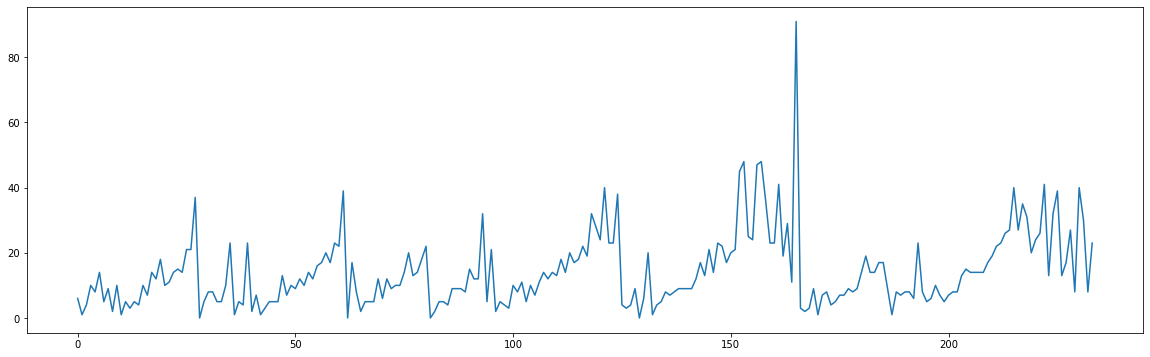

In [29]:
plt.plot(lst)

## Using timesynth

In [30]:
import timesynth as ts

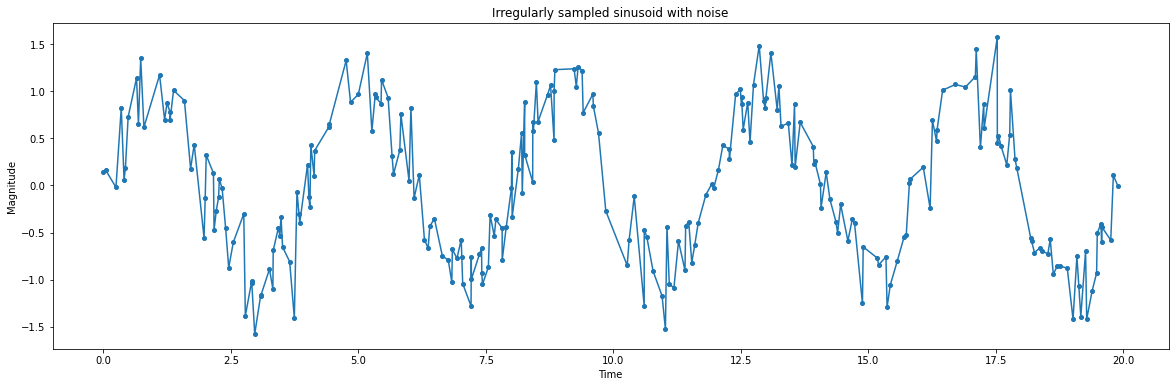

In [31]:
time_sampler = ts.TimeSampler(stop_time=20)

irregular_time_samples = time_sampler.sample_irregular_time(num_points=500, keep_percentage=50)

sinusoid = ts.signals.Sinusoidal(frequency=0.25)

white_noise = ts.noise.GaussianNoise(std=0.3)

timeseries = ts.TimeSeries(signal_generator=sinusoid, noise_generator=white_noise)

samples, signals, errors = timeseries.sample(irregular_time_samples)

plt.plot(irregular_time_samples, samples, marker='o', markersize=4)
plt.xlabel('Time') #name of variable plotted on X-axis
plt.ylabel('Magnitude') #name of variable on Y-axis
plt.title('Irregularly sampled sinusoid with noise'); #title of the plot 

In [32]:
from datetime import datetime , timedelta, timezone


start_date = '2022_01_25'
end_date = '2022_01_30'

start = datetime.strptime(start_date, "%Y_%m_%d")
print(type(start))
end =  datetime.strptime(end_date, "%Y_%m_%d")
##pDate = str(pDate).replace('-', '_')
number_of_days = len(lst)
print("number_of_days: ", number_of_days)

##
date_list = []
for day in range(number_of_days):
    a_date = (start + timedelta(days = day)).astimezone(timezone.utc)
    a_date = a_date.strftime('%Y-%m-%d')
    date_list.append(start_date)

print(date_list)

<class 'datetime.datetime'>
number_of_days:  234
['2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25', '2022_01_25'

In [33]:
df = pd.DataFrame(date_list, columns = ['date'])
df['value'] = lst
df = df.set_index('date').sort_index()
df.head()

value
date             
2022_01_25      6
2022_01_25      1
2022_01_25      4
2022_01_25     10
2022_01_25      8

In [34]:
a = df.values.squeeze()

m = 24
profile = matrixProfile.stomp(a,m)

In [35]:
df['profile'] = np.append(profile[0],np.zeros(m-1)+np.nan)
df['profile_index'] = np.append(profile[1], np.zeros(m - 1) + np.nan)

In [36]:
ex_zone = 24
anoms = discords(df['profile'], ex_zone, k=5)

In [37]:
anomalies2 = df.iloc[anoms]

anomalies

Date
2013-04-26    32.15
2014-06-16       32
2013-03-18    32.35
2013-09-12    30.74
2014-04-25    30.04
2013-07-12    30.94
2013-11-13    31.44
2014-09-10    36.17
2014-03-20    29.89
2014-02-05    29.93
2013-02-05    30.58
2014-11-10    40.16
2013-06-06    31.66
2013-12-26     32.3
2014-07-23    32.71
Name: ZTS, dtype: object

KeyError: 'value'

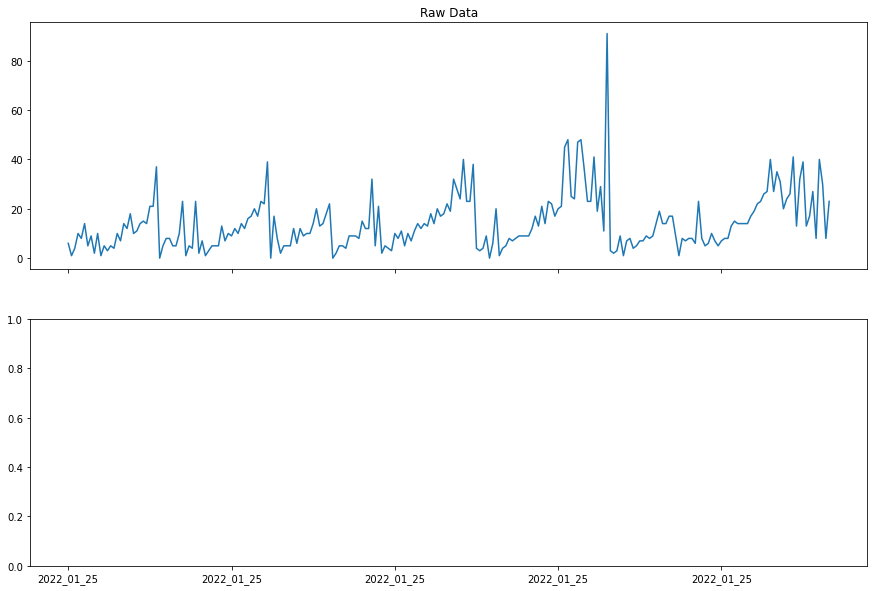

In [38]:
#Plot the signal data
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(15,10))
#ax1.plot(df['value'])
df['value'].plot(ax=ax1, title='Raw Data')
ax1.plot(anomalies["value"], 'ro')

#Plot the Matrix Profile
df['profile'].plot(ax=ax2, c='r', title='Matrix Profile')


plt.show()

## Emani PCA

In [213]:
high_dim_df = pd.read_csv('high-dim-asset-prices.csv')
high_dim_df.head()

Date   CDNS  HII  NCLH  SBAC  IQV  BHF       AOS        DRE  \
0  2003-01-02  11.66  NaN   NaN  0.46  NaN  NaN  3.665609  11.131988   
1  2003-01-03   9.24  NaN   NaN  0.42  NaN  NaN  3.593985  11.326909   
2  2003-01-06   9.80  NaN   NaN  0.48  NaN  NaN  3.555615  11.521826   
3  2003-01-07   9.36  NaN   NaN  0.57  NaN  NaN  3.521080  11.283589   
4  2003-01-08   9.65  NaN   NaN  0.63  NaN  NaN  3.485269  11.157979   

         MGM  ...        WAT  WU  WRK         WY        WHR  WYN       XEL  \
0  16.932493  ...  22.020000 NaN  NaN  11.924259  37.775433  NaN  6.074376   
1  16.676165  ...  21.680000 NaN  NaN  11.856510  37.092781  NaN  6.176063   
2  16.138859  ...  21.920000 NaN  NaN  12.171902  38.256065  NaN  6.556044   
3  16.079704  ...  21.290001 NaN  NaN  12.146206  37.629150  NaN  6.315211   
4  13.950205  ...  20.910000 NaN  NaN  11.896222  37.698792  NaN  6.743364   

         XRX         XL       ZION  
0  17.462282  53.263206  33.542156  
1  17.719086  53.575237  33.236809  
2  18.061478  55.082233  34.161186  
3  17.783279  54.776875  34.326260  
4  17.697674  54.086426  34.689415  

[5 rows x 504 columns]

In [214]:
high_dim_df['Date'] = pd.to_datetime(high_dim_df['Date'], infer_datetime_format=True)
high_dim_df.columns

Index(['Date', 'CDNS', 'HII', 'NCLH', 'SBAC', 'IQV', 'BHF', 'AOS', 'DRE',
       'MGM',
       ...
       'WAT', 'WU', 'WRK', 'WY', 'WHR', 'WYN', 'XEL', 'XRX', 'XL', 'ZION'],
      dtype='object', length=504)

In [215]:
high_dim_df = high_dim_df.set_index('Date').sort_index()

In [216]:
#high_dim_df = high_dim_df.drop(columns=['Date'])
high_dim_df.head()
high_dim_df.isna() # there are some NA entries

CDNS    HII   NCLH   SBAC    IQV    BHF    AOS    DRE    MGM  \
Date                                                                        
2003-01-02  False   True   True  False   True   True  False  False  False   
2003-01-03  False   True   True  False   True   True  False  False  False   
2003-01-06  False   True   True  False   True   True  False  False  False   
2003-01-07  False   True   True  False   True   True  False  False  False   
2003-01-08  False   True   True  False   True   True  False  False  False   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2017-12-22  False  False  False  False  False  False  False  False  False   
2017-12-26  False  False  False  False  False  False  False  False  False   
2017-12-27  False  False  False  False  False  False  False  False  False   
2017-12-28  False  False  False  False  False  False  False  False  False   
2017-12-29  False  False  False  False  False  False  False  False  False   

              PKG  ...    WAT     WU    WRK     WY    WHR    WYN    XEL  \
Date               ...                                                    
2003-01-02  False  ...  False   True   True  False  False   True  False   
2003-01-03  False  ...  False   True   True  False  False   True  False   
2003-01-06  False  ...  False   True   True  False  False   True  False   
2003-01-07  False  ...  False   True   True  False  False   True  False   
2003-01-08  False  ...  False   True   True  False  False   True  False   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
2017-12-22  False  ...  False  False  False  False  False  False  False   
2017-12-26  False  ...  False  False  False  False  False  False  False   
2017-12-27  False  ...  False  False  False  False  False  False  False   
2017-12-28  False  ...  False  False  False  False  False  False  False   
2017-12-29  False  ...  False  False  False  False  False  False  False   

              XRX     XL   ZION  
Date                             
2003-01-02  False  False  False  
2003-01-03  False  False  False  
2003-01-06  False  False  False  
2003-01-07  False  False  False  
2003-01-08  False  False  False  
...           ...    ...    ...  
2017-12-22  False  False  False  
2017-12-26  False  False  False  
2017-12-27  False  False  False  
2017-12-28  False  False  False  
2017-12-29  False  False  False  

[3776 rows x 503 columns]

In [217]:
high_dim_df= high_dim_df.dropna()
pca = PCA(n_components=1)
pca.fit(high_dim_df.values)

PCA(n_components=1)

In [218]:
Z = pca.transform(high_dim_df)
Z = pd.DataFrame(Z, columns=['pc1'], index=high_dim_df.index) #may want to set the index as the date next time
Z.head()

pc1
Date                  
2017-10-16  236.815517
2017-10-17  228.144587
2017-10-18  234.749364
2017-10-19  237.871322
2017-10-20  242.358363

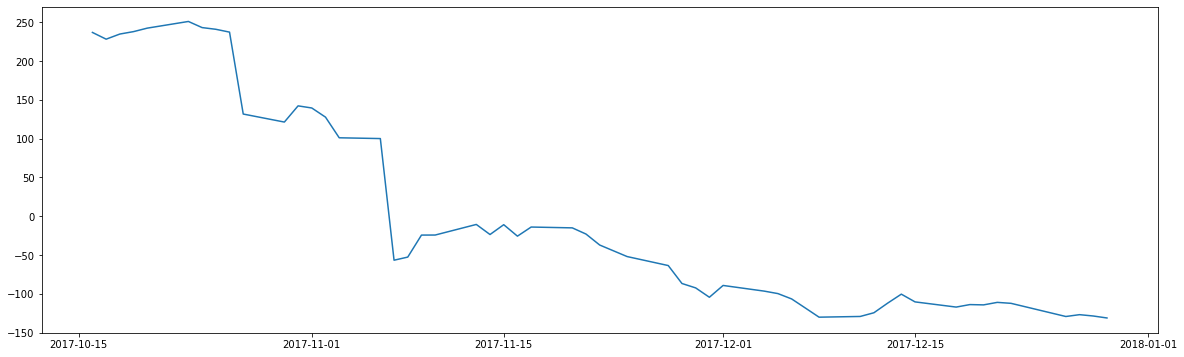

In [219]:
plt.plot(Z['pc1'])
plt.show()

In [220]:
comp = pd.DataFrame(pca.components_, columns=high_dim_df.columns, index=['pc1'])
comp

CDNS       HII      NCLH      SBAC       IQV       BHF       AOS  \
pc1 -0.002622 -0.009652  0.003304 -0.048081  0.007433  0.008725 -0.003239   

          DRE       MGM       PKG  ...       WAT        WU       WRK  \
pc1  0.000385 -0.008342 -0.000926  ... -0.020004  0.001518 -0.008852   

           WY       WHR      WYN       XEL       XRX        XL      ZION  
pc1 -0.001827  0.005105 -0.01611 -0.003017  0.008178  0.014504 -0.011212  

[1 rows x 503 columns]

In [221]:
a = Z.values.squeeze()
m = 3
profile = matrixProfile.stomp(a,m)

Z['profile'] = np.append(profile[0],np.zeros(m-1)+np.nan)
Z['profile_index'] = np.append(profile[1], np.zeros(m - 1) + np.nan)
Z.head()

pc1   profile  profile_index
Date                                           
2017-10-16  236.815517  0.059753           22.0
2017-10-17  228.144587  0.321381           40.0
2017-10-18  234.749364  0.209886           40.0
2017-10-19  237.871322  0.123051           39.0
2017-10-20  242.358363  0.053748           19.0

In [222]:
Z.tail()

pc1   profile  profile_index
Date                                           
2017-12-22 -112.182086  0.101482           37.0
2017-12-26 -129.150598  0.232307           41.0
2017-12-27 -126.791755  0.056435            6.0
2017-12-28 -128.509813       NaN            NaN
2017-12-29 -131.050823       NaN            NaN

In [223]:
len(Z)

53

In [224]:
len(a)

53

In [225]:
len(profile[1])

51

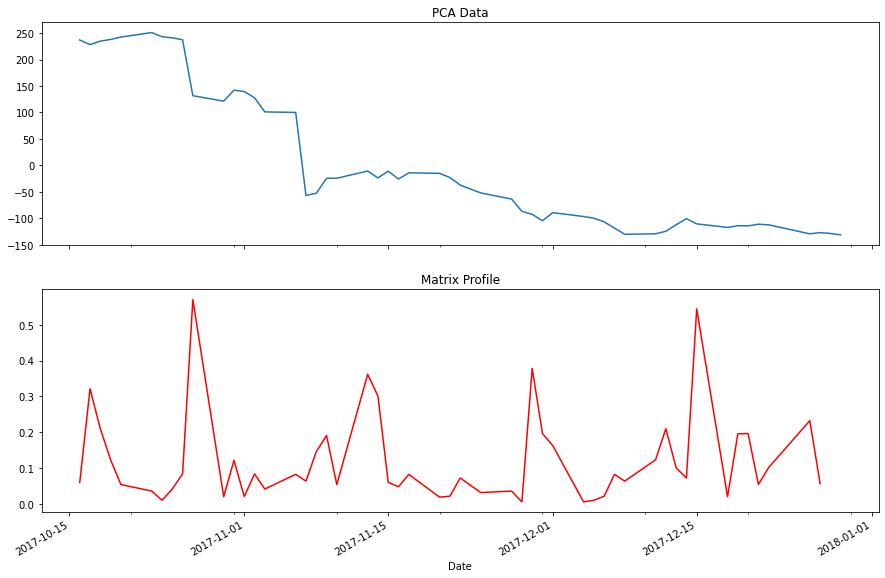

In [226]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(15,10))
Z['pc1'].plot(ax=ax1, title='PCA Data')

#Plot the Matrix Profile
Z['profile'].plot(ax=ax2, c='r', title='Matrix Profile')
plt.show()

In [227]:
# exclude up to a day on the left and right side
np.uint64
ex_zone = 24

# we look for the 5 events specified in the data explaination
anoms = discords(np.uint64(Z['profile']),ex_zone, k=5) #np.uint64 to get rid of overflow error

Z.iloc[anoms]

pc1   profile  profile_index
Date                                           
2017-12-28 -128.509813       NaN            NaN
2017-11-22  -37.071133  0.072116           42.0
2017-10-19  237.871322  0.123051           39.0
2017-10-16  236.815517  0.059753           22.0
2017-10-16  236.815517  0.059753           22.0

array([51, 27,  3,  0,  0])

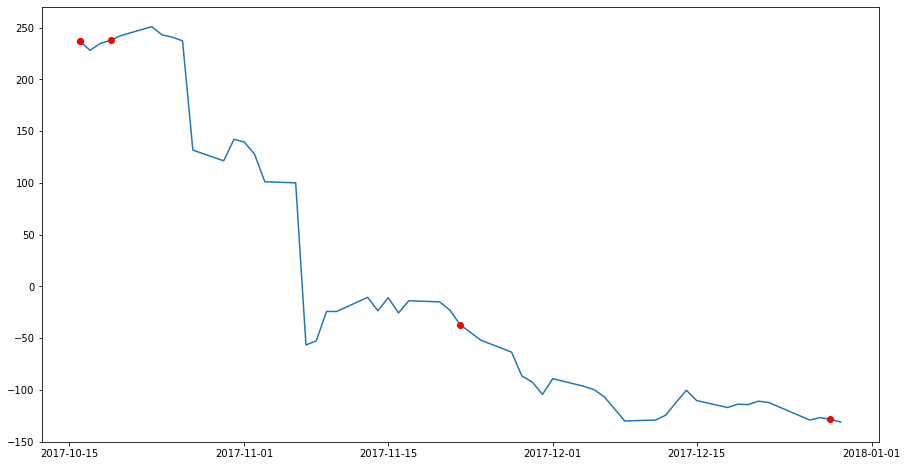

In [228]:
plt.figure(figsize=(15,8))
anomalies = Z.iloc[anoms]
anomalies["pc1"]
plt.plot(Z["pc1"])
plt.plot(anomalies["pc1"], 'ro')
# df.columns
# anoms
anomalies["pc1"]
anoms                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

PyOD, Tensorflow